In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_info.csv
/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv
/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv


In [2]:
from datetime import datetime

# Define the dateparse function using datetime.strptime
def dateparse(dates):
    return datetime.strptime(dates, '%Y-%m-%d')

# Read the CSV data using pandas with the dateparse function
data = pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

market_data = pd.read_csv('/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv')


In [3]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00


In [4]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


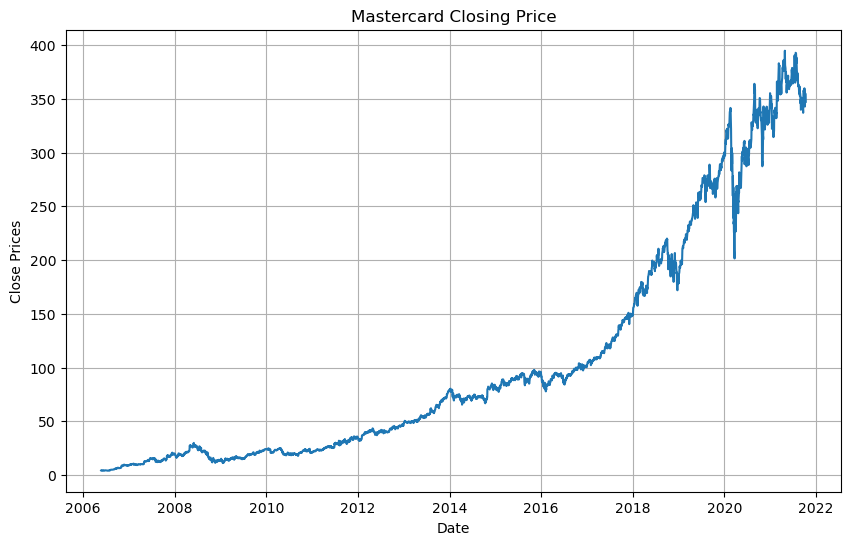

In [5]:
#Visualize the stock’s daily closing price.

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Mastercard Closing Price')
plt.show()

<Axes: ylabel='Density'>

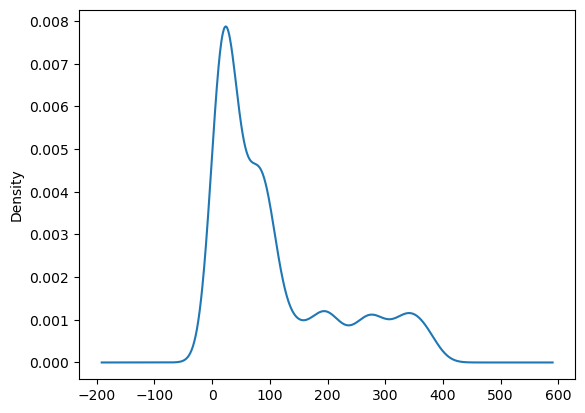

In [6]:
#Distribution of the dataset
df_close = data['Close']
df_close.plot(kind='kde')

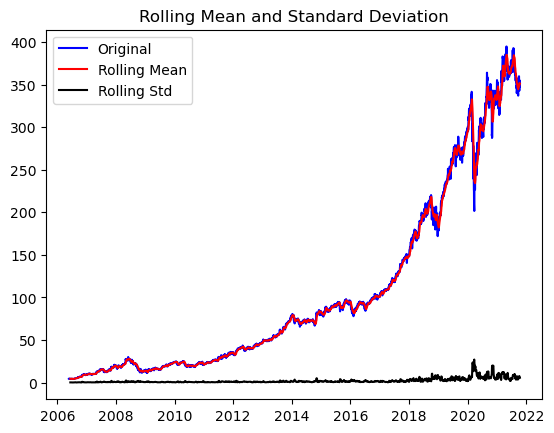

Results of Augmented Dickey-Fuller Test:
Test Statistics                   1.203926
p-value                           0.996013
No. of Lags Used                 28.000000
Number of Observations Used    3843.000000
Critical Value (1%)              -3.432053
Critical Value (5%)              -2.862292
Critical Value (10%)             -2.567171
dtype: float64

Results of KPSS Test:
Test Statistics           8.057294
p-value                   0.010000
Number of Lags Used      39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_20/2407355754.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(timeseries, regression='c', nlags='auto')


In [7]:
from statsmodels.tsa.stattools import kpss

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of Augmented Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])
    for key, value in adft[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

    print("\nResults of KPSS Test:")
    kpss_test = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistics', 'p-value', 'Number of Lags Used'])
    for key, value in kpss_test[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)

test_stationarity(df_close)


Both the Augmented Dickey-Fuller Test and KPSS Test indicate that the time series data is non-stationary. This means that the data requires differencing or other transformations to make it suitable for ARIMA modeling, as ARIMA assumes stationary data.

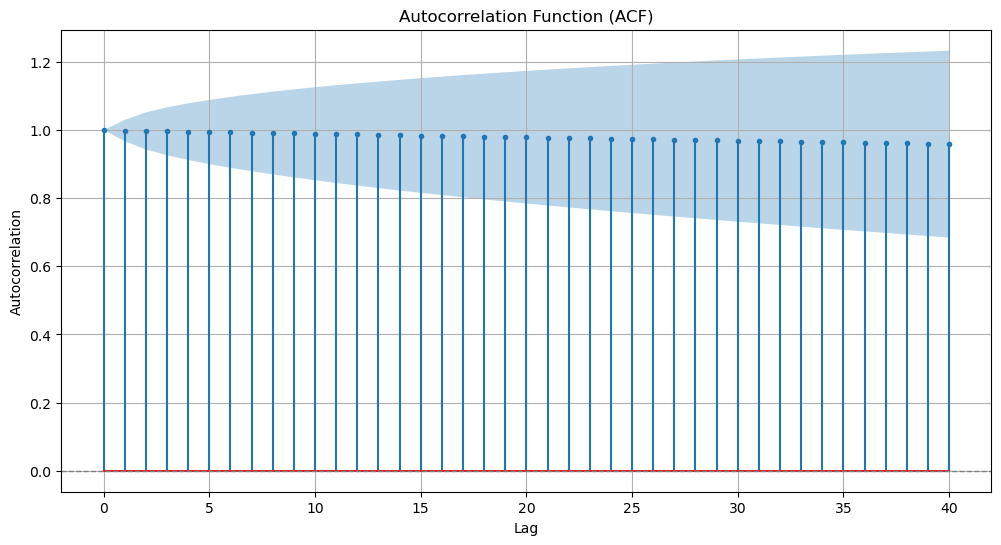

ACF Values:
Lag 0: ACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: ACF Value = 0.9988437189595502, Confidence Interval = [0.9673459  1.03034153]
Lag 2: ACF Value = 0.9977314128356216, Confidence Interval = [0.94321764 1.05224518]
Lag 3: ACF Value = 0.9965952125752459, Confidence Interval = [0.92626042 1.06693   ]
Lag 4: ACF Value = 0.9955063671490026, Confidence Interval = [0.91233354 1.07867919]
Lag 5: ACF Value = 0.9945077978373202, Confidence Interval = [0.90025202 1.08876357]
Lag 6: ACF Value = 0.9935112874482287, Confidence Interval = [0.88936409 1.09765849]
Lag 7: ACF Value = 0.9925187188708945, Confidence Interval = [0.87935867 1.10567877]
Lag 8: ACF Value = 0.9914976467626304, Confidence Interval = [0.87000755 1.11298775]
Lag 9: ACF Value = 0.9905018063007563, Confidence Interval = [0.86123282 1.11977079]
Lag 10: ACF Value = 0.9894464955526029, Confidence Interval = [0.8528552  1.12603779]
Lag 11: ACF Value = 0.9883812387211224, Confidence Interval = [0.84485512 1.1319073

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf


# Calculate ACF and PACF values
acf_values, confint_acf = acf(data['Close'], nlags=40, alpha=0.05)

# Plot ACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(acf_values)), confint_acf[:, 0], confint_acf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Print ACF values with confidence intervals
print("ACF Values:")
for lag, acf_val, conf_int in zip(range(len(acf_values)), acf_values, confint_acf):
    print(f"Lag {lag}: ACF Value = {acf_val}, Confidence Interval = {conf_int}")


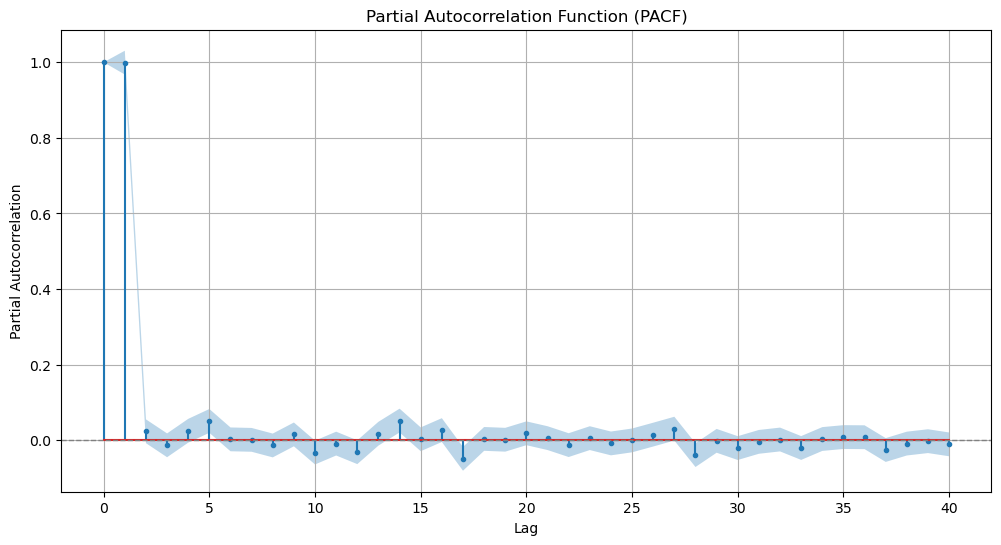

PACF Values:
Lag 0: PACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: PACF Value = 0.9991017514366778, Confidence Interval = [0.96760394 1.03059957]
Lag 2: PACF Value = 0.023793959079472304, Confidence Interval = [-0.00770386  0.05529177]
Lag 3: PACF Value = -0.01341087142366341, Confidence Interval = [-0.04490869  0.01808694]
Lag 4: PACF Value = 0.02508586581127185, Confidence Interval = [-0.00641195  0.05658368]
Lag 5: PACF Value = 0.051154973398887665, Confidence Interval = [0.01965716 0.08265279]
Lag 6: PACF Value = 0.0023631392280840232, Confidence Interval = [-0.02913467  0.03386095]
Lag 7: PACF Value = 0.0010560401175935155, Confidence Interval = [-0.03044177  0.03255385]
Lag 8: PACF Value = -0.01382340364465352, Confidence Interval = [-0.04532122  0.01767441]
Lag 9: PACF Value = 0.015443524028389782, Confidence Interval = [-0.01605429  0.04694134]
Lag 10: PACF Value = -0.03252863127485632, Confidence Interval = [-0.06402645 -0.00103082]
Lag 11: PACF Value = -0.008840716670

In [9]:
pacf_values, confint_pacf = pacf(data['Close'], nlags=40, alpha=0.05)

# Plot PACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(pacf_values)), confint_pacf[:, 0], confint_pacf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

# Print PACF values with confidence intervals
print("PACF Values:")
for lag, pacf_val, conf_int in zip(range(len(pacf_values)), pacf_values, confint_pacf):
    print(f"Lag {lag}: PACF Value = {pacf_val}, Confidence Interval = {conf_int}")

<Figure size 640x480 with 0 Axes>

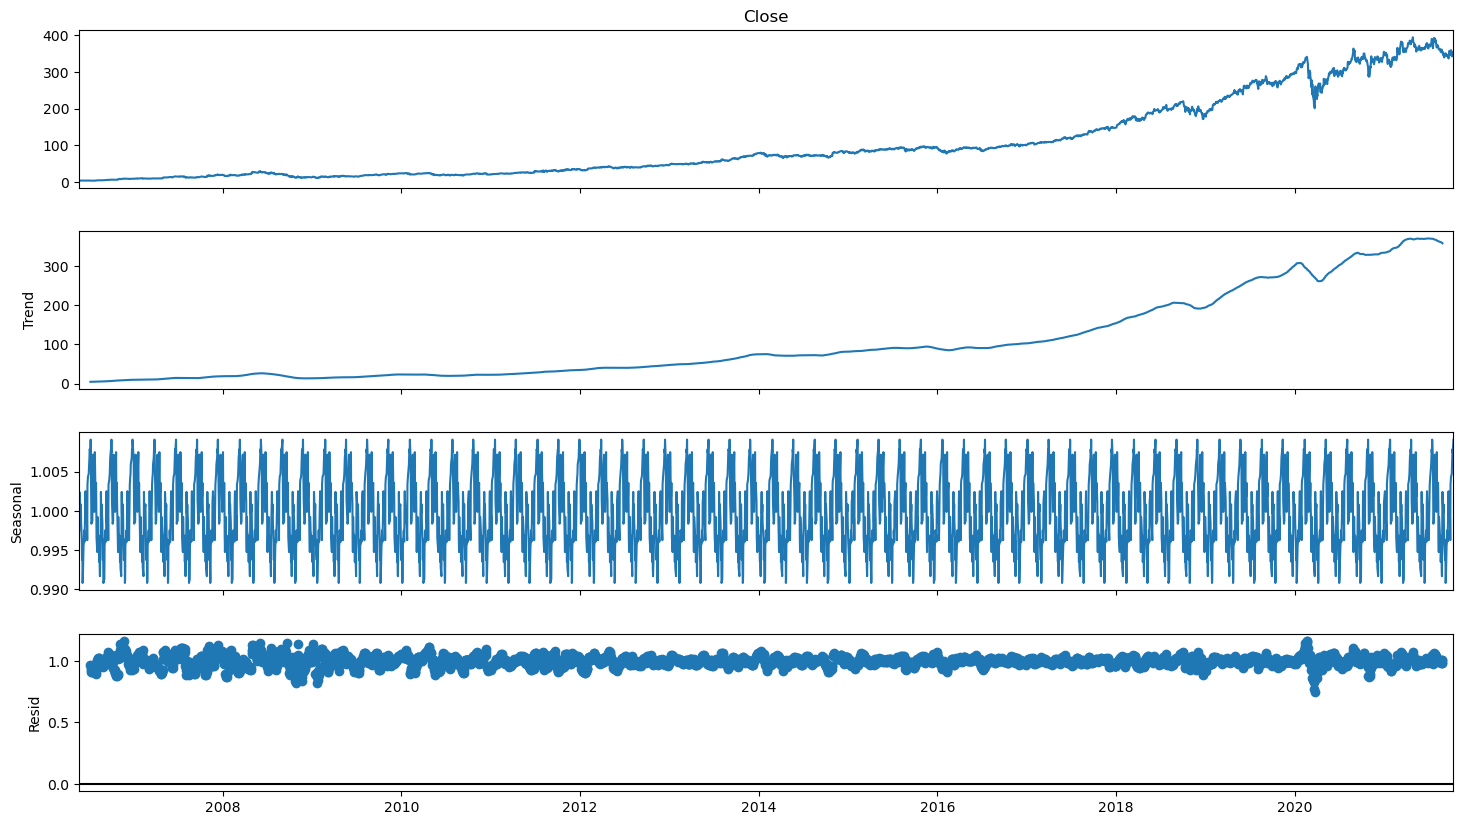

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Let's isolate the time series from the Trend and Seasonality.
# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(data['Close'], model='multiplicative', period=60)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()


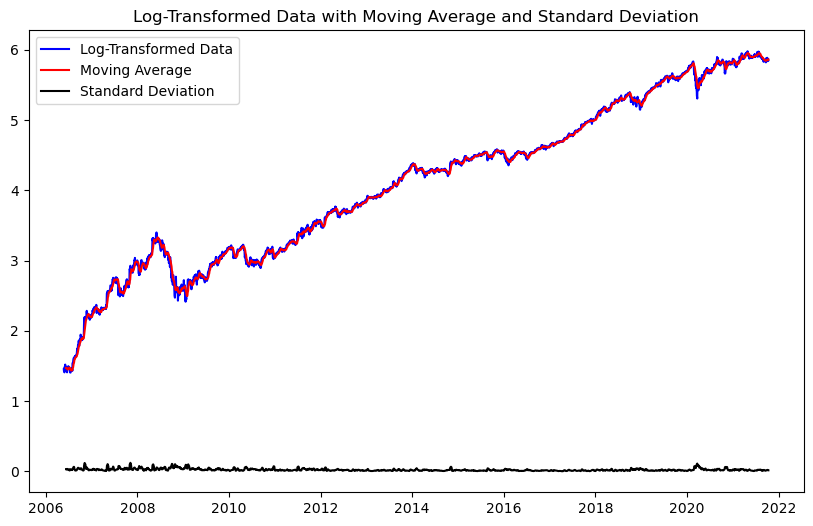

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Take the log transformation
df_log = np.log(df_close)

# Calculate the moving average
moving_avg = df_log.rolling(12).mean()

# Calculate the standard deviation
std_dev = df_log.rolling(12).std()

# Plot the original log-transformed data, moving average, and standard deviation
plt.plot(df_log, color='blue', label='Log-Transformed Data')
plt.plot(moving_avg, color='red', label='Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.legend(loc='best')
plt.title('Log-Transformed Data with Moving Average and Standard Deviation')
plt.show()


<Figure size 1000x600 with 0 Axes>

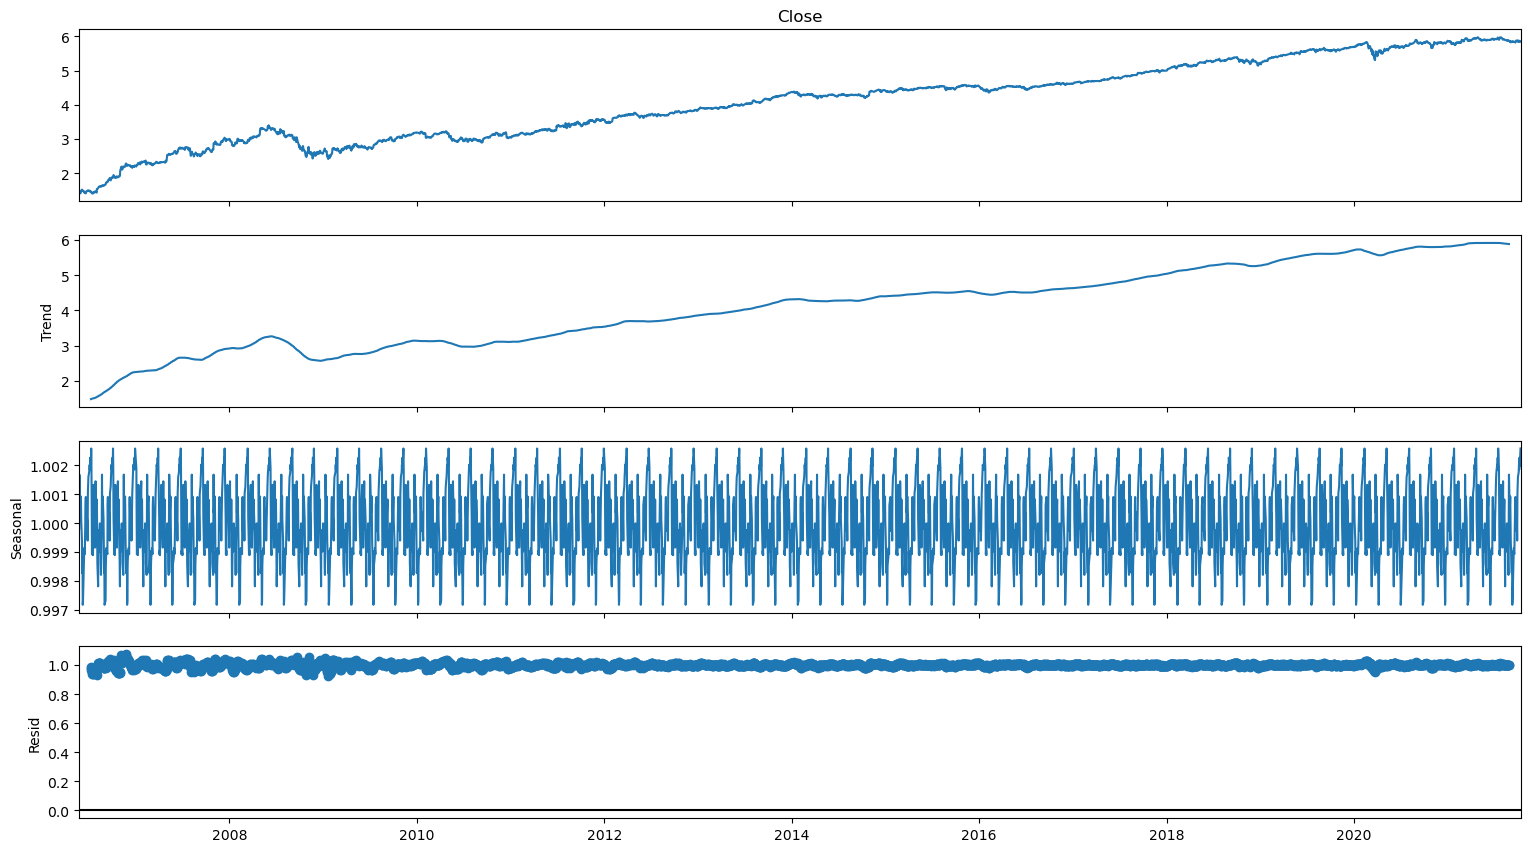

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Let's isolate the time series from the Trend and Seasonality.
# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_log, model='multiplicative', period=60)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

In [13]:
print("Results of Augmented Dickey-Fuller Test:")
adft = adfuller(df_log, autolag='AIC')
adf_output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])
for key, value in adft[4].items():
    adf_output['Critical Value (%s)' % key] = value
print(adf_output)

print("\nResults of KPSS Test:")
kpss_test = kpss(df_log, regression='c', nlags='auto')
kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistics', 'p-value', 'Number of Lags Used'])
for key, value in kpss_test[3].items():
    kpss_output['Critical Value (%s)' % key] = value
print(kpss_output)


Results of Augmented Dickey-Fuller Test:
Test Statistics                  -2.108513
p-value                           0.241105
No. of Lags Used                 18.000000
Number of Observations Used    3853.000000
Critical Value (1%)              -3.432048
Critical Value (5%)              -2.862290
Critical Value (10%)             -2.567169
dtype: float64

Results of KPSS Test:
Test Statistics           9.504541
p-value                   0.010000
Number of Lags Used      39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_20/3474766842.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df_log, regression='c', nlags='auto')
